In [34]:
### 1. Find suitable dataset with a target
### 2. Clean Data
### 3. Explore data, find correlation between features and target, and features and features
### 4. Feature Engineering find good features
### 5. Try multiple models or multiple sets of different features
### 6. Tune hyperparameters if applicable
### 7. Compare models and choose best one and explain

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
import xgboost as xgb
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

import warnings
warnings.filterwarnings('ignore')

In [35]:
df = pd.read_csv("student_depression_dataset.csv")

def plot_categorical_counts(category_col):
    plt.figure(figsize=(20, 15))
    
    # Create a contingency table (cross-tabulation)
    cross_tab = pd.crosstab(df[category_col], df['Depression'])

    # Plot the bar graph
    ax = cross_tab.plot(kind='bar', stacked=False)
    plt.title(f'Counts of {category_col} by Depression')
    plt.xlabel(category_col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Depression')

    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, label_type='edge')
    
    plt.show()

In [36]:
# df.info()
df.head()
# df.corr()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


In [37]:
### clean -> explore

# Drop id work pressure, and job satisfaction as they do not contain any data
df = df.drop('id', axis = 1)
df = df.drop('Work Pressure', axis = 1)
df = df.drop('Job Satisfaction', axis = 1)

# Drop all non student rows then drop that column, 99% of data is student data
df = df[df['Profession'] == 'Student']
df = df.drop('Profession', axis = 1)

# Drop 'Others' rows essentially non existent data
df = df[df['Sleep Duration'] != 'Others']
df = df[df['Dietary Habits'] != 'Others']
df = df[df['Degree'] != 'Others']

# Column name too long
df.rename(columns = {'Have you ever had suicidal thoughts ?': 'SuicidalThoughts'}, inplace = True)

<Figure size 1440x1080 with 0 Axes>

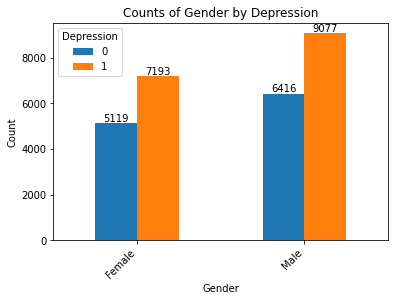

<Figure size 1440x1080 with 0 Axes>

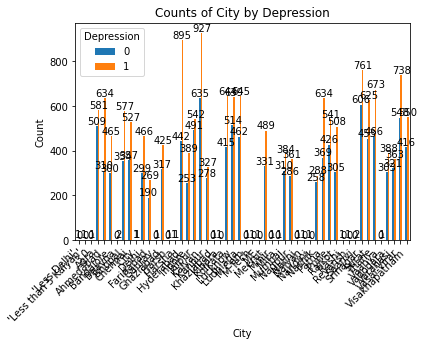

<Figure size 1440x1080 with 0 Axes>

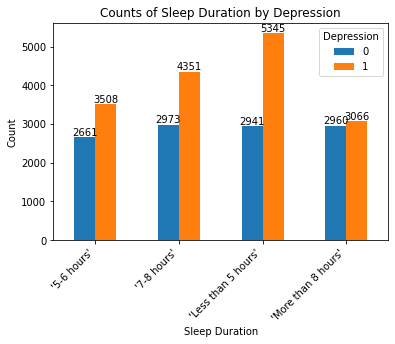

<Figure size 1440x1080 with 0 Axes>

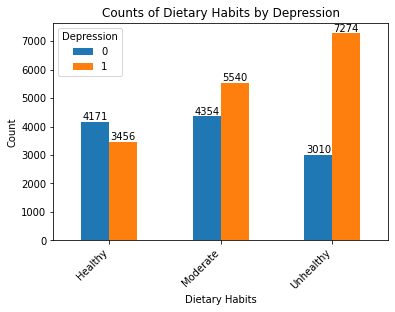

<Figure size 1440x1080 with 0 Axes>

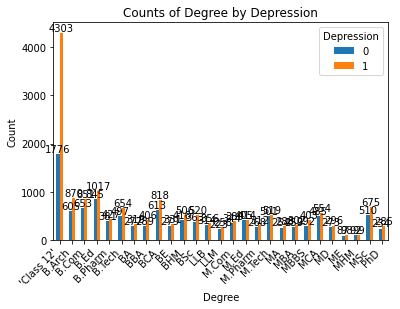

<Figure size 1440x1080 with 0 Axes>

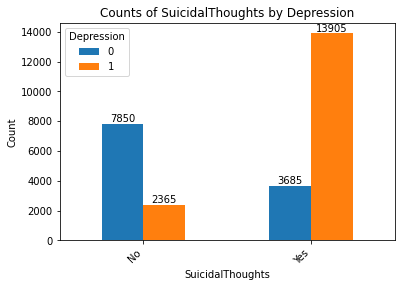

<Figure size 1440x1080 with 0 Axes>

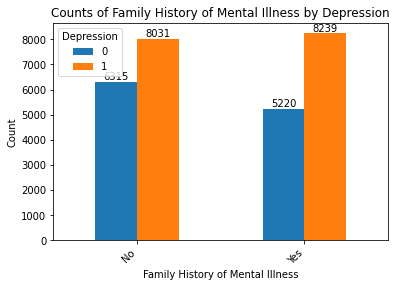

In [38]:
### clean -> explore

plot_categorical_counts('Gender')
plot_categorical_counts('City')
plot_categorical_counts('Sleep Duration')
plot_categorical_counts('Dietary Habits')
plot_categorical_counts('Degree')
plot_categorical_counts('SuicidalThoughts')
plot_categorical_counts('Family History of Mental Illness')

In [39]:
### clean -> explore

# Quarter of data is class 12 and of the remaining university data it is primarily 50-55% with some 56-59%
# This is already a bloated categorical column so we are going to group all degrees together for the purposes 
# of this analysis. We can then use this as a binary column later.
#df['Education'] = pd.Series(dtype = 'string')

df['Education'] = df['Degree'].where(df['Degree'].eq("'Class 12'"), 'University')
df['Education'] = df['Education'].replace("'Class 12'", 'High School')
df = df.drop('Degree', axis = 1)
df = df.drop('City', axis = 1)

# Make Financial Stress a numeric field
df['Financial Stress'] = pd.to_numeric(df['Financial Stress'], errors = 'coerce')

df.dropna()
df['Financial Stress'] = df['Financial Stress'].fillna(df['Financial Stress'].mean())

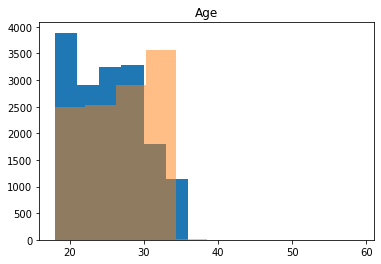

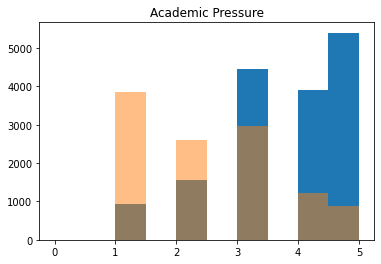

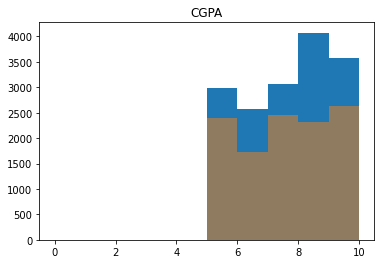

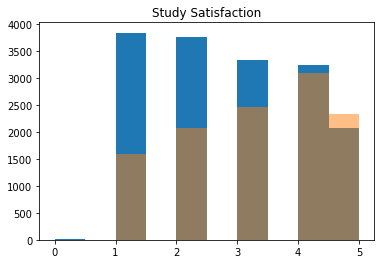

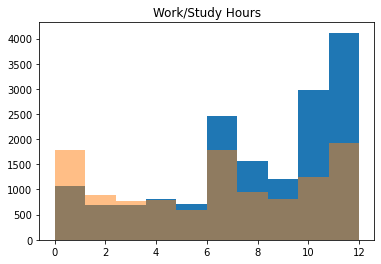

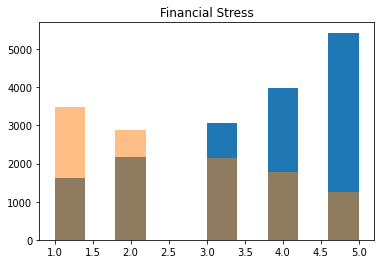

In [40]:
### explore

df_dep = df[df['Depression'] == 1]
df_no_dep = df[df['Depression'] == 0] 

plt.hist(df_dep['Age'])
plt.hist(df_no_dep['Age'], alpha = 0.5)
plt.title('Age')
plt.show()

plt.hist(df_dep['Academic Pressure'])
plt.hist(df_no_dep['Academic Pressure'], alpha = 0.5)
plt.title('Academic Pressure')
plt.show()

plt.hist(df_dep['CGPA'])
plt.hist(df_no_dep['CGPA'], alpha = 0.5)
plt.title('CGPA')
plt.show()

plt.hist(df_dep['Study Satisfaction'])
plt.hist(df_no_dep['Study Satisfaction'], alpha = 0.5)
plt.title('Study Satisfaction')
plt.show()

plt.hist(df_dep['Work/Study Hours'])
plt.hist(df_no_dep['Work/Study Hours'], alpha = 0.5)
plt.title('Work/Study Hours')
plt.show()

plt.hist(df_dep['Financial Stress'])
plt.hist(df_no_dep['Financial Stress'], alpha = 0.5)
plt.title('Financial Stress')
plt.show()


In [ ]:
# Explore -> Models

# For categorical columns we will initially include all but city. 
# For numeric columns we will include all but cgpa. The other five fields all seem to have notable correlation to depression so
# it makes sense to include all in the model for now.

In [ ]:
df.info()

[0.77238403 0.79467817 0.78892485 0.78101402 0.78964401 0.78345324
 0.77086331 0.78165468 0.78165468 0.77877698]



<AxesSubplot: >

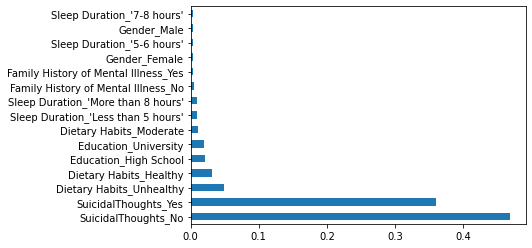

In [41]:
# Random Forest

df_cat = df.select_dtypes(include = ['object'])
rfc = ensemble.RandomForestClassifier(n_estimators = 10, n_jobs = -1)
X = df_cat
Y = df['Depression']
X = pd.get_dummies(X)

print(f'{cross_val_score(rfc, X, Y, cv = 10)}\n')

rfc.fit(X, Y)

feat_importances = pd.Series(rfc.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
# Random Forest estimated accuracy is about 78% notably higher than the linear regression models using our numeric fields. 
# Top three impactful fields are Thoughts, Dietery Habits, and Education. Add these fields along with numeric fields to see
# if that produces better or worse results.

In [ ]:
# Random Forest produced a higher estimated accuracy still at 78% compared to an rsqsuared 51% above using linear regression with numeric 
# fields plus the three categorical fields. That model was an improvement from before increasing the rsquared by about 20% and
# lowering the mean value errors. I would still stick with random forest.

In [ ]:
######
######
######

In [ ]:
### Revisions 4/18
### Perform and compare logistic regression and xgboost

In [42]:
# Prepare dataset

df_dummies = df.select_dtypes(include = ['object'])
df_dummies = pd.get_dummies(df_dummies, columns = df_dummies.columns)
df_dummies = pd.concat([df_dummies, df['Depression']], axis = 1)
df_dummies.head()

X_train, X_test = train_test_split(df_dummies, test_size = 0.3, random_state = 37)

Y_train = X_train['Depression']
X_train = X_train.drop(['Depression'], axis = 1)

Y_test = X_test['Depression']
X_test = X_test.drop(['Depression'], axis = 1)

In [43]:
# Logistic Regression

c_space = np.logspace(0.1, 1, 10, 100, 1000)
param_grid = {'C': c_space}
lr = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
lr = GridSearchCV(lr, param_grid, cv = 5)
lr.fit(X_train, Y_train)
lr_predictions = lr.predict(X_test)

accuracy = accuracy_score(Y_test, lr_predictions)
precision = precision_score(Y_test, lr_predictions)
recall = recall_score(Y_test, lr_predictions)
f1 = f1_score(Y_test, lr_predictions)
fbeta_precision = fbeta_score(Y_test, lr_predictions, beta = 0.5)
fbeta_recall = fbeta_score(Y_test, lr_predictions, beta = 2)

print('Accuracy score: {:.4f}'.format(accuracy))
print('Precision score: {:.4f}'.format(precision))
print('Recall score: {:.4f}'.format(recall))
print('F1 score: {:.4f}'.format(f1))
print('Fbeta score favoring precision: {:.4f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.4f}'.format(fbeta_recall))

Accuracy score: 0.7878
Precision score: 0.7929
Recall score: 0.8645
F1 score: 0.8271
Fbeta score favoring precision: 0.8063
FBeta score favoring recall: 0.8491


In [44]:
# XGBoost

xgb_classifier = xgb.XGBClassifier(
    objective = 'binary:logistic', n_estimators = 500, learning_rate = 0.5, max_depth = 5, random_state = 37)
param_dist = {
    "max_depth": [5, None], "max_features": randint(1, 7), "min_samples_leaf": randint(1, 7), "criterion": ["gini", "entropy"]}
xgb_classifier = RandomizedSearchCV(xgb_classifier, param_dist, cv = 5)
xgb_classifier.fit(X_train, Y_train)
xgb_predictions = xgb_classifier.predict(X_test)

accuracy = accuracy_score(Y_test, xgb_predictions)
precision = precision_score(Y_test, xgb_predictions)
recall = recall_score(Y_test, xgb_predictions)
f1 = f1_score(Y_test, xgb_predictions)
fbeta_precision = fbeta_score(Y_test, xgb_predictions, beta = 0.5)
fbeta_recall = fbeta_score(Y_test, xgb_predictions, beta = 2)

print('Accuracy score: {:.4f}'.format(accuracy))
print('Precision score: {:.4f}'.format(precision))
print('Recall score: {:.4f}'.format(recall))
print('F1 score: {:.4f}'.format(f1))
print('Fbeta score favoring precision: {:.4f}'.format(fbeta_precision))
print('FBeta score favoring recall: {:.4f}'.format(fbeta_recall))

Accuracy score: 0.7834
Precision score: 0.7898
Recall score: 0.8600
F1 score: 0.8234
Fbeta score favoring precision: 0.8029
FBeta score favoring recall: 0.8450


In [ ]:
# Both models produced nearly identical scores. Logistical Regression technically scored better so I would recommend that. It
# is my understanding that this can be the result of the dataset being too 'easy'. Perhaps reassessing the features selected,
# or creating new ones to help push the models more and identify a more suited one.

# Accuracy and Precision are very close at around 78/79%, while recall is about 7% higher. This would tell me that false 
# negatives are relatively low compared to false positives. The scores are not particularly low by any means to indicate any 
# obvious innaccuracy but this could be something to propell further analysis. Possibly individual features are tipping the 
# scales at times. SuicidalThoughts has a significant impact, while there are others that have a much more balanced split
# as far as the target variable is concerned.